In [1]:
from __future__ import division
import logging, gensim, bz2
from gensim import corpora, models, similarities
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
from bs4 import BeautifulSoup
import nltk
import re
from nltk.corpus import stopwords
import string
import itertools
import random
exclude = set(string.punctuation)
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (18.0, 18.0)
import numpy as np
from lightning import Lightning
from numpy import random, asarray
import networkx as nx
import math
import random
import pickle
from nltk.stem.wordnet import WordNetLemmatizer
import os
import sys
import networkx as nx
from scipy.sparse import *
from scipy import *
import numpy as np

In [79]:
import izi
reload(izi)
import pickle


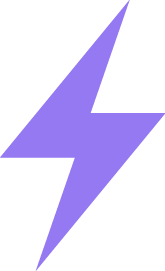

Connected to server at https://desolate-castle-4773.herokuapp.com


<IPython.core.display.Javascript object>

In [3]:
lgn = Lightning(ipython=True, host='https://desolate-castle-4773.herokuapp.com/')
lgn.set_size(size='large')

In [4]:
colours = []
colours.append("#1abc9c" )
colours.append( "#f1c40f")
colours.append( "#3498db")
colours.append( "#9b59b6")
colours.append( "#e74c3c")
colours.append( "#2ecc71")
colours.append( "#34495e")

# Build the corpus network

## get all filenames

In [5]:
filelist = izi.getFileList(u"all_source_texts/")
print len(filelist)

195


## load pre-built data

In [6]:
# from topic id to name
topic_names = pickle.load( open( "topics_names.p", "rb" ) )
# simulated translators
translated_by = pickle.load( open( "translated_by.p", "rb" ) )
# load lda
lda = gensim.models.ldamodel.LdaModel.load(u'lda/wikipedia_lda', mmap='r')
# load semantics vectors
semantics_vectors = pickle.load( open( "semantics_vectors.p", "rb" ) )
# load topic description
topics = pickle.load( open( "topics.p", "rb" ) )

# build graph

In [149]:
graph, filename2id = izi.getGraph(semantics_vectors, colours[0])

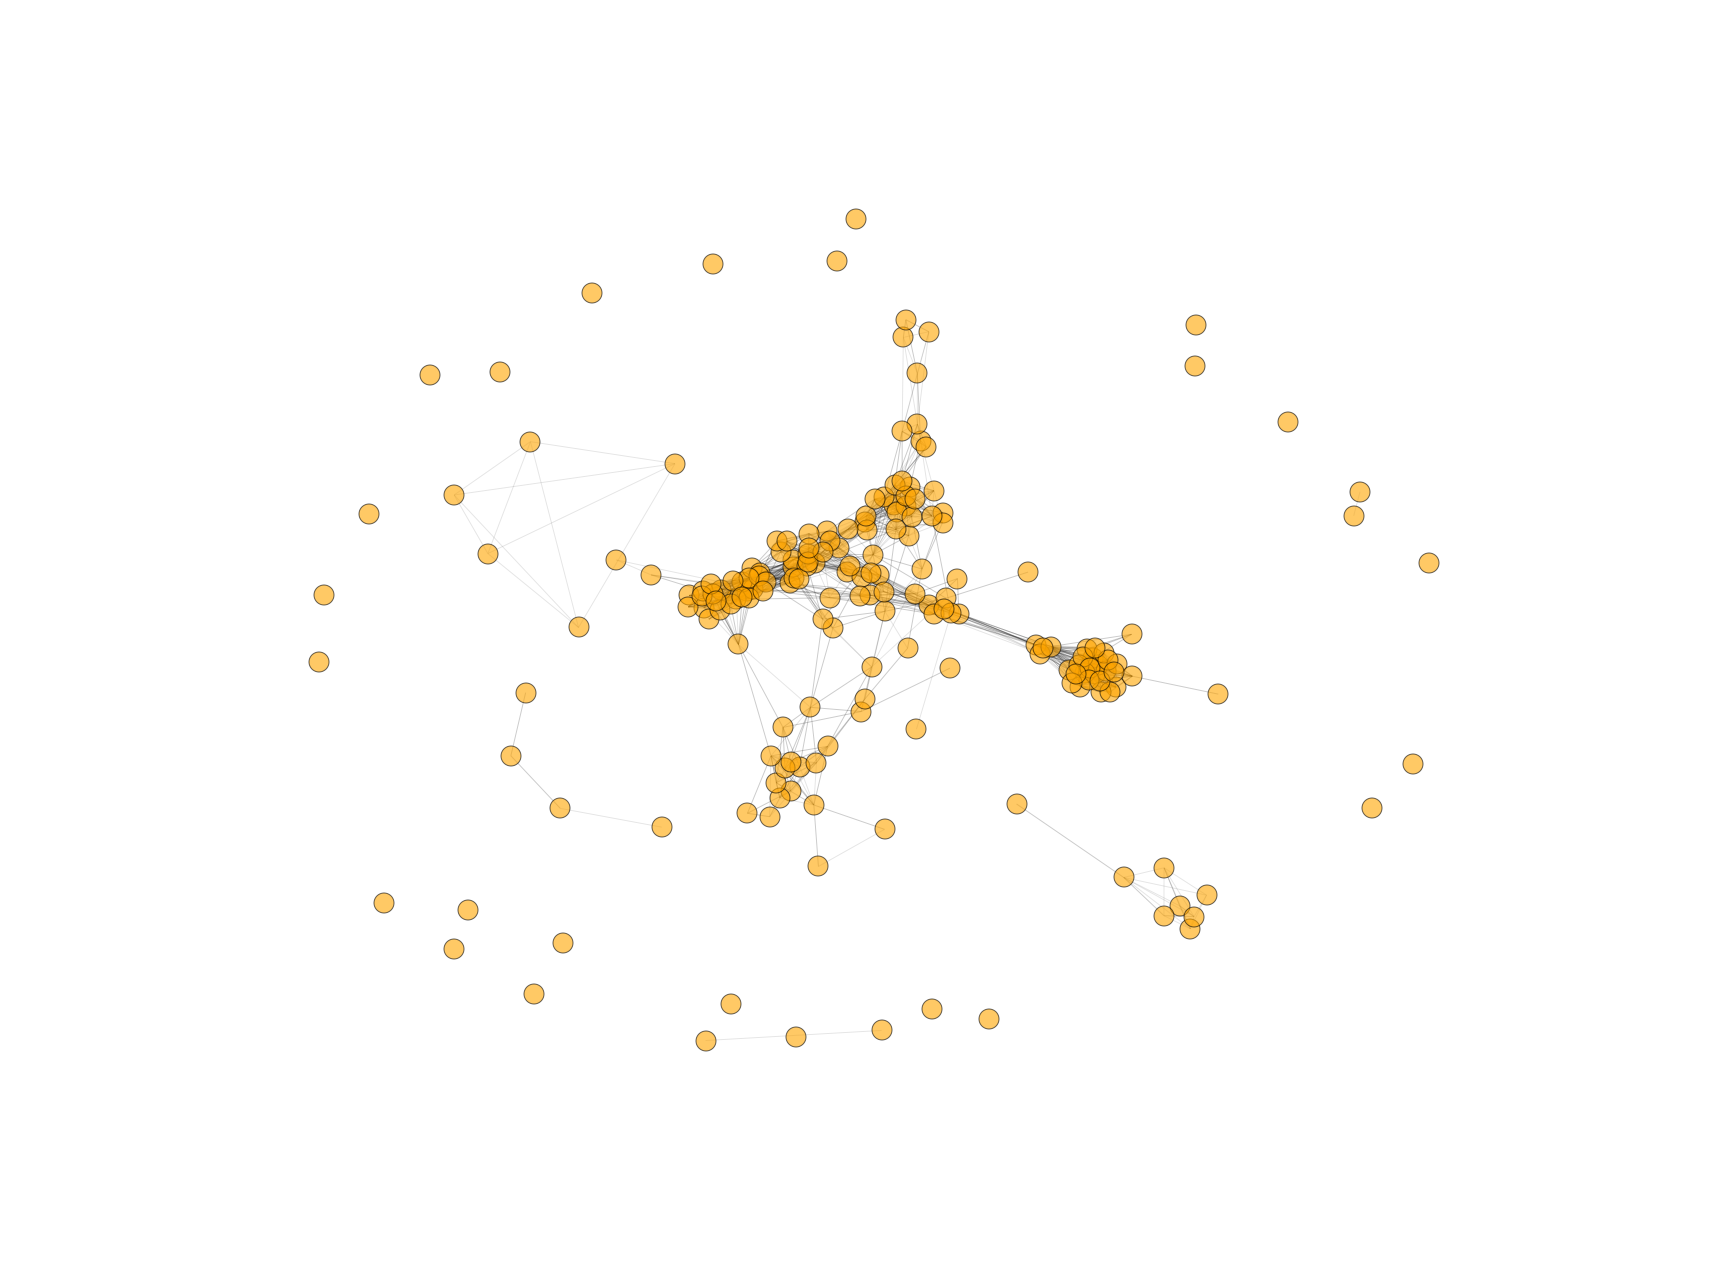

In [150]:
pos = izi.plotGraphNX( graph )

In [151]:
mat = asarray(nx.adjacency_matrix(graph).todense())
# weights =  nx.get_node_attributes(graph, 'weight').values()
labels = nx.get_node_attributes(graph, 'label').values()
# colors = nx.get_node_attributes(graph, 'color').values()
# colors = np.vstack(colors)
lgn.force(mat, labels = labels)

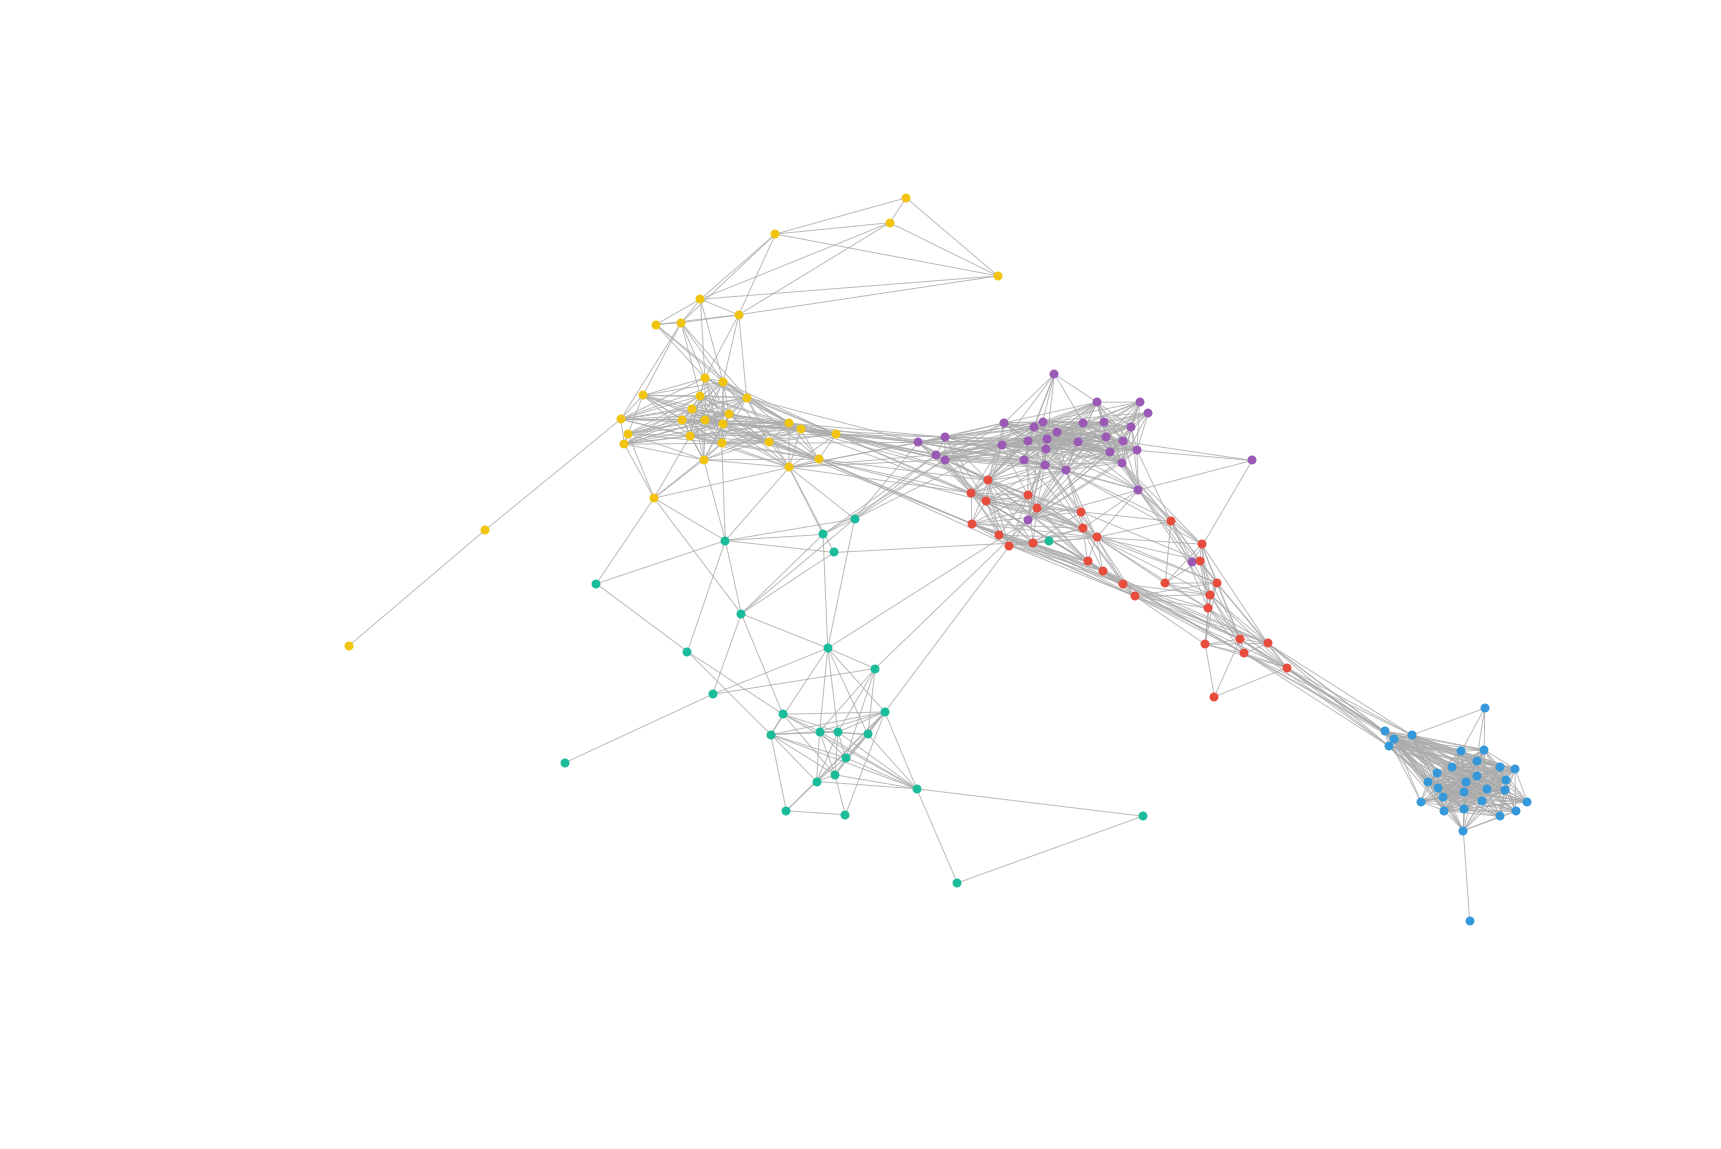

modularity: 0.712466617201
5 communities


In [152]:
sub_graphs_louvain = izi.LouvainModularity(graph, colours)

In [66]:
for n in sub_graphs_louvain[0].nodes():
    print filename2id[n]

all_source_texts/Text1_1070Woerter-en-de-T.mxliff
all_source_texts/Q & A_en-GB-en-it-T.mxliff
all_source_texts/Product IQ Quizzes v2-en-da-T.mxliff
all_source_texts/Salesfolder Revlonissimo-en-de-T.mxliff
all_source_texts/Beth�s Blog 1 v3-en-da-T.mxliff
all_source_texts/ELX Weekly Wellness Tips v3-en-da-T.mxliff
all_source_texts/Re-Nutriv Script_Final Translation Template_deadline 20. april-en-da-T.mxliff
all_source_texts/1920-0002 Princess PLC-en-fr_ca-CR.mxliff
all_source_texts/1920-0001 Fairy PLC-en-fr_ca-CR.mxliff
all_source_texts/Beth�s Blog 2 v1-en-da-T.mxliff
all_source_texts/1920-0002 Princess Interiors-en-fr_ca-CR.mxliff
all_source_texts/Sprout_PR_interview_en-GB-en-it-T.mxliff
all_source_texts/Personlig s�tning_en-GB-en-it-T.mxliff
all_source_texts/Text variables for e-mail report_Final[1]-en-fr-T.mxliff
all_source_texts/Sprout blyanten_en-GB-en-it-T.mxliff
all_source_texts/EL GMTC_Final Translation Template (2)_deadline 20. april-en-da-T.mxliff
all_source_texts/ANR script_Fi

# clusters

In [144]:
graph0, filename2id = izi.getGraph(semantics_vectors, colours[0], 0.6)

In [73]:
graph_thres, filename2id = izi.getGraph(semantics_vectors, colours[0], 0.90)

In [145]:
# get hyper connected clusters
THRESH = 0.1

added_nodes = set()
groups = []
files = graph0.nodes()
for a in files:
    if a not in added_nodes:
        added_nodes.add(a)
        g = set()
        g.add( a )
        for b in files:
            if b not in added_nodes:
                try:
                    connected_to_all_nodes = True
                    for x in g:
                        if connected_to_all_nodes:
                            d = nx.shortest_path_length(graph0, a,b, weight = 'weight')
                            if d > THRESH:
                                connected_to_all_nodes = False
                    if connected_to_all_nodes:
                        g.add(b)
                        added_nodes.add(b)
                except:
                    0
                
        groups.append(g)

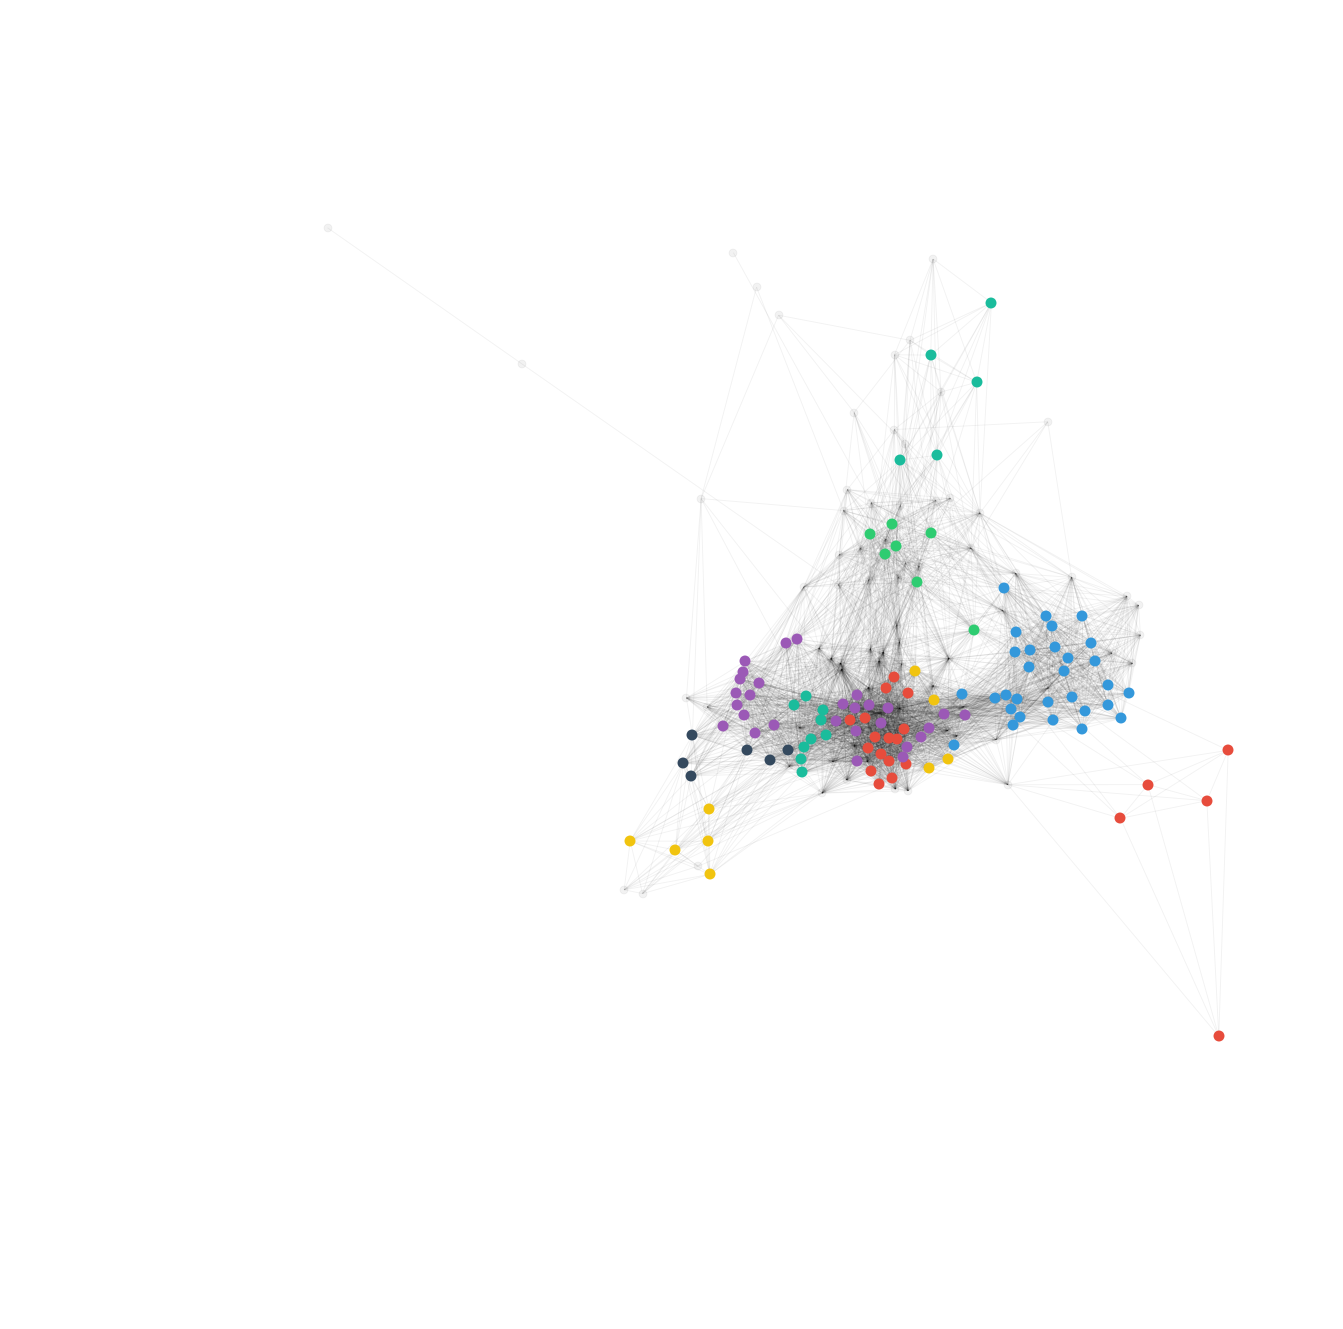

In [147]:
graphs = list(nx.connected_component_subgraphs(graph0))
graphs.sort(key=lambda x: len( x.nodes() ), reverse = True)
G = graphs[0]
pos=nx.spring_layout(G)
k = 0
# nx.draw_networkx_edges(graph0,pos,  edge_color = "#aaaaaa", alpha = 0.1)
nx.draw( G, pos, node_color = 'black',  node_size = 60, alpha = 0.05)
for g in groups:
    if len(g) > 3:
        nx.draw_networkx_nodes(G, pos, g, linewidths = 0,  node_size = 120, node_color = colours[k])
        k += 1
        if k >= len(colours):
            k = 0
plt.axis('off')
plt.savefig('hyper_connected_clusters.png')
plt.show()

# Fast Greedy algorithm: communities

ImportError: No module named agglomcluster

# adjancy matrix

In [78]:
def groupFromLouvain( i ):
    n = 0
    result = -1
    for g in sub_graphs_louvain:
        if i in g.nodes():
            result = n
        n += 1
    return result

values = []
groups = []
n_g = 0
for g in sub_graphs_louvain:
    files = [ filename2id[f] for f in g.nodes()]
    for f in files:
        for ff in files:
            groups.append( n_g )
            s = izi.similarity(izi.semantic_vec_to_dok(semantics_vectors[f]),izi.semantic_vec_to_dok(semantics_vectors[ff] ))
            if s == None or s < 0.2:
                s = 0
            values.append( ( filename2id[f], filename2id[ff] ,  s))
    n_g += 1
Adj = np.vstack(values)


In [80]:
lgn.adjacency(Adj,numbers = False)

NetworkXNotImplemented: not implemented for undirected type

In [ ]:
M = np.vstack( [izi.semantic_vec_to_dok(semantics_vectors[f]).todense() for f in filelist])
print 
lgn.adjacency(M)